## K-means++

In this notebook, we are going to implement [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) algorithm with multiple initial sets. The original k-means++ algorithm will just sample one set of initial centroid points and iterate until the result converges. The only difference in this implementation is that we will sample `RUNS` sets of initial centroid points and update them in parallel. The procedure will finish when all centroid sets are converged.

In [16]:
### Definition of some global parameters.
K = 5  # Number of centroids
RUNS = 25 # Number of K-means runs that are executed in parallel. Equivalently, number of sets of initial points
RANDOM_SEED = 60295531
converge_dist = 0.1 # The K-means algorithm is terminated when the change in the location 
                    # of the centroids is smaller than 0.1

In [17]:
import numpy as np
import pickle
import sys
from numpy.linalg import norm
from matplotlib import pyplot as plt


def print_log(s):
    sys.stdout.write(s + "\n")
    sys.stdout.flush()


def parse_data(row):
    '''
    Parse each pandas row into a tuple of (station_name, feature_vec),
    where feature_vec is the concatenation of the projection vectors
    of TAVG, TRANGE, and SNWD.
    '''
    return (row[0],
            np.concatenate([row[1], row[2], row[3]]))


def compute_entropy(d):
    '''
    Compute the entropy given the frequency vector `d`
    '''
    d = np.array(d)
    d = 1.0 * d / d.sum()
    return -np.sum(d * np.log2(d))


def choice(p):
    '''
    Generates a random sample from [0, len(p)),
    where p[i] is the probability associated with i. 
    '''
    random = np.random.random()
    r = 0.0
    for idx in range(len(p)):
        r = r + p[idx]
        if r > random:
            return idx
    assert(False)


def kmeans_init(rdd, K, RUNS, seed):
    '''
    Select `RUNS` sets of initial points for `K`-means++
    '''
    # the `centers` variable is what we want to return
    n_data = rdd.count()
    shape = rdd.take(1)[0][1].shape[0]
    centers = np.zeros((RUNS, K, shape))

    def update_dist(vec, dist, k):
        new_dist = norm(vec - centers[:, k], axis=1)**2
        return np.min([dist, new_dist], axis=0)

    def cal_dist(x,indexList):
        return [norm(x-centers[b,indexList[b]])**2 for b in range(RUNS)]
    
    # The second element `dist` in the tuple below is the closest distance from
    # each data point to the selected points in the initial set, where `dist[i]`
    # is the closest distance to the points in the i-th initial set.
    data = rdd.map(lambda p: (p, [np.inf] * RUNS)) \
              .cache()

    # Collect the feature vectors of all data points beforehand, might be
    # useful in the following for-loop
    local_data = rdd.map(lambda (name, vec): vec).collect()

    # Randomly select the first point for every run of k-means++,
    # i.e. randomly select `RUNS` points and add it to the `centers` variable
    sample = [local_data[k] for k in np.random.randint(0, len(local_data), RUNS)]
    centers[:, 0] = sample
    
    for idx in range(K - 1):
        closest_center_index=data.map(lambda ((name,vec),dist):(vec,get_closest(vec,centers)))\
            .map(lambda (vec,indexList):(vec,cal_dist(vec,indexList)))\
            .flatMap(lambda (vec,indexList):[(r,(vec,indexList[r])) for r in range(RUNS)])\
            .groupByKey().mapValues(list).sortByKey()
        least_dist=closest_center_index.collect()
        for r in range(RUNS):
            # p is the index to be choosen 
            r_dist_list=(map(lambda (vec,dist_r):dist_r,least_dist[r][1]))   
            p=choice(r_dist_list/sum(r_dist_list))
            centers[r,idx+1]= least_dist[r][1][p][0]


#         closest_center_index=data.map(lambda ((name,vec),dist):(vec,get_closest(vec,centers)))
#         least_dist=closest_center_index.map(lambda (vec,indexList):(vec,cal_dist(vec,indexList))).cache()
#         for r in range(RUNS):
#         # p has center for rth set - choosen as a point with highest distance in that 
#             r_vec_dist_list=least_dist.map(lambda (vec,dist):(vec,dist[r])).collect()#.sortBy(lambda x:-x[1]).take(1)
#             p=choice(map(lambda (vec,dist_r):dist_r,r_vec_dist_list))
#             centers[r,idx+1]=r_vec_dist_list[p][0]
        pass

    return centers


def get_closest(p, centers):
    '''
    Return the indices the nearest centroids of `p`.
    `centers` contains sets of centroids, where `centers[i]` is
    the i-th set of centroids.
    '''
    best = [0] * len(centers)
    closest = [np.inf] * len(centers)
    for idx in range(len(centers)):
        for j in range(len(centers[0])):
            temp_dist = norm(p - centers[idx][j])
            if temp_dist < closest[idx]:
                closest[idx] = temp_dist
                best[idx] = j
    return best

def avg_list(vecList):
    '''
    Calculates sum of lists in the vecList and divides them by #list. i.e. an average of lists
    Input type list[List]
    Return type - numpy array
    '''
    return np.mean(np.array(vecList), axis=0)

def kmeans(rdd, K, RUNS, converge_dist, seed):
    '''
    Run K-means++ algorithm on `rdd`, where `RUNS` is the number of
    initial sets to use.
    '''
    k_points = kmeans_init(rdd, K, RUNS, seed)
    print_log("Initialized.")
    temp_dist = 1.0
    
    new_points=np.zeros((RUNS,K,len(k_points[0][0])))
    iters = 0
    st = time.time()
    
    while temp_dist > converge_dist:
        '''
        closest_centers_indx=rdd.map(lambda x:(x[1],get_closest(x[1],k_points))).cache()
        for idx in range(RUNS):
            closest_r_center=closest_centers_indx.map(lambda x:(x[0],x[1][idx])) \
            .map(lambda x:(x[1],x[0])).groupByKey().mapValues(list) \
            .map(lambda x:(x[0],avg_list(x[1]))).sortByKey().collect()
            # filter points of idxth set # group per closest centroid index # take group wise average
            for j in range(K):
                new_points[idx][j]=closest_r_center[j][1] # jth new centroid for idx'th set 
        '''
        closest_centers_indx=rdd.map(lambda (name,vec):(vec,get_closest(vec,k_points))).cache()
        RUN_K_vec=closest_centers_indx.flatMap(lambda (vec,indexList): [((r,indexList[r]),(vec,1)) for r in range(RUNS)]).cache()
        closest_center_vec=RUN_K_vec.reduceByKey(lambda x,y:(x[0]+y[0],x[1]+y[1]))\
                    .map(lambda ((idx,k),(vecSum,tot)):(idx,k,vecSum/float(tot))).collect()
        l=closest_center_vec
        for i in range(len(l)):
            new_points[l[i][0]][l[i][1]]=l[i][2] # l has structure (RUN,K,AVG_VEC) 
        
        temp_dist = np.max([
                np.sum([norm(k_points[idx][j] - new_points[(idx, j)]) for j in range(K)])
                    for idx in range(RUNS)])

        iters = iters + 1
        if iters % 5 == 0:
            print_log("Iteration %d max shift: %.2f (time: %.2f)" %
                      (iters, temp_dist, time.time() - st))
            st = time.time()

        # update old centroids
        # You modify this for-loop to meet your need
        for idx in range(RUNS):
            for j in range(K):
                k_points[idx][j] = new_points[idx][j]

    return k_points


In [18]:
import pickle
## Read data
data = pickle.load(open("./Data/Weather/stations_projections.pickle", "rb"))
rdd = sc.parallelize([parse_data(row[1]) for row in data.iterrows()])
rdd.take(1)

[(u'USC00044534', array([  3.04796236e+03,   1.97434852e+03,   1.50560792e+02,
          -2.90363288e+03,  -2.36907268e+02,   1.47021791e+02,
           1.91503001e-01,   1.87262808e-01,  -4.01379553e-02]))]

In [19]:
# collecting all points for populatin g
rdd_t=rdd.map(lambda (name,vec):(name,vec[:2])).cache()
l=rdd_t.map(lambda x:x[1]).collect()
x_pop=[]
y_pop=[]
for i in range(len(l)):
    x_pop.append(l[i][0])
    y_pop.append(l[i][1])

In [20]:
import time
st = time.time()
k_points = kmeans_init(rdd_t, K, RUNS, np.random.randint(1000))
print time.time()-st

85.3193747997


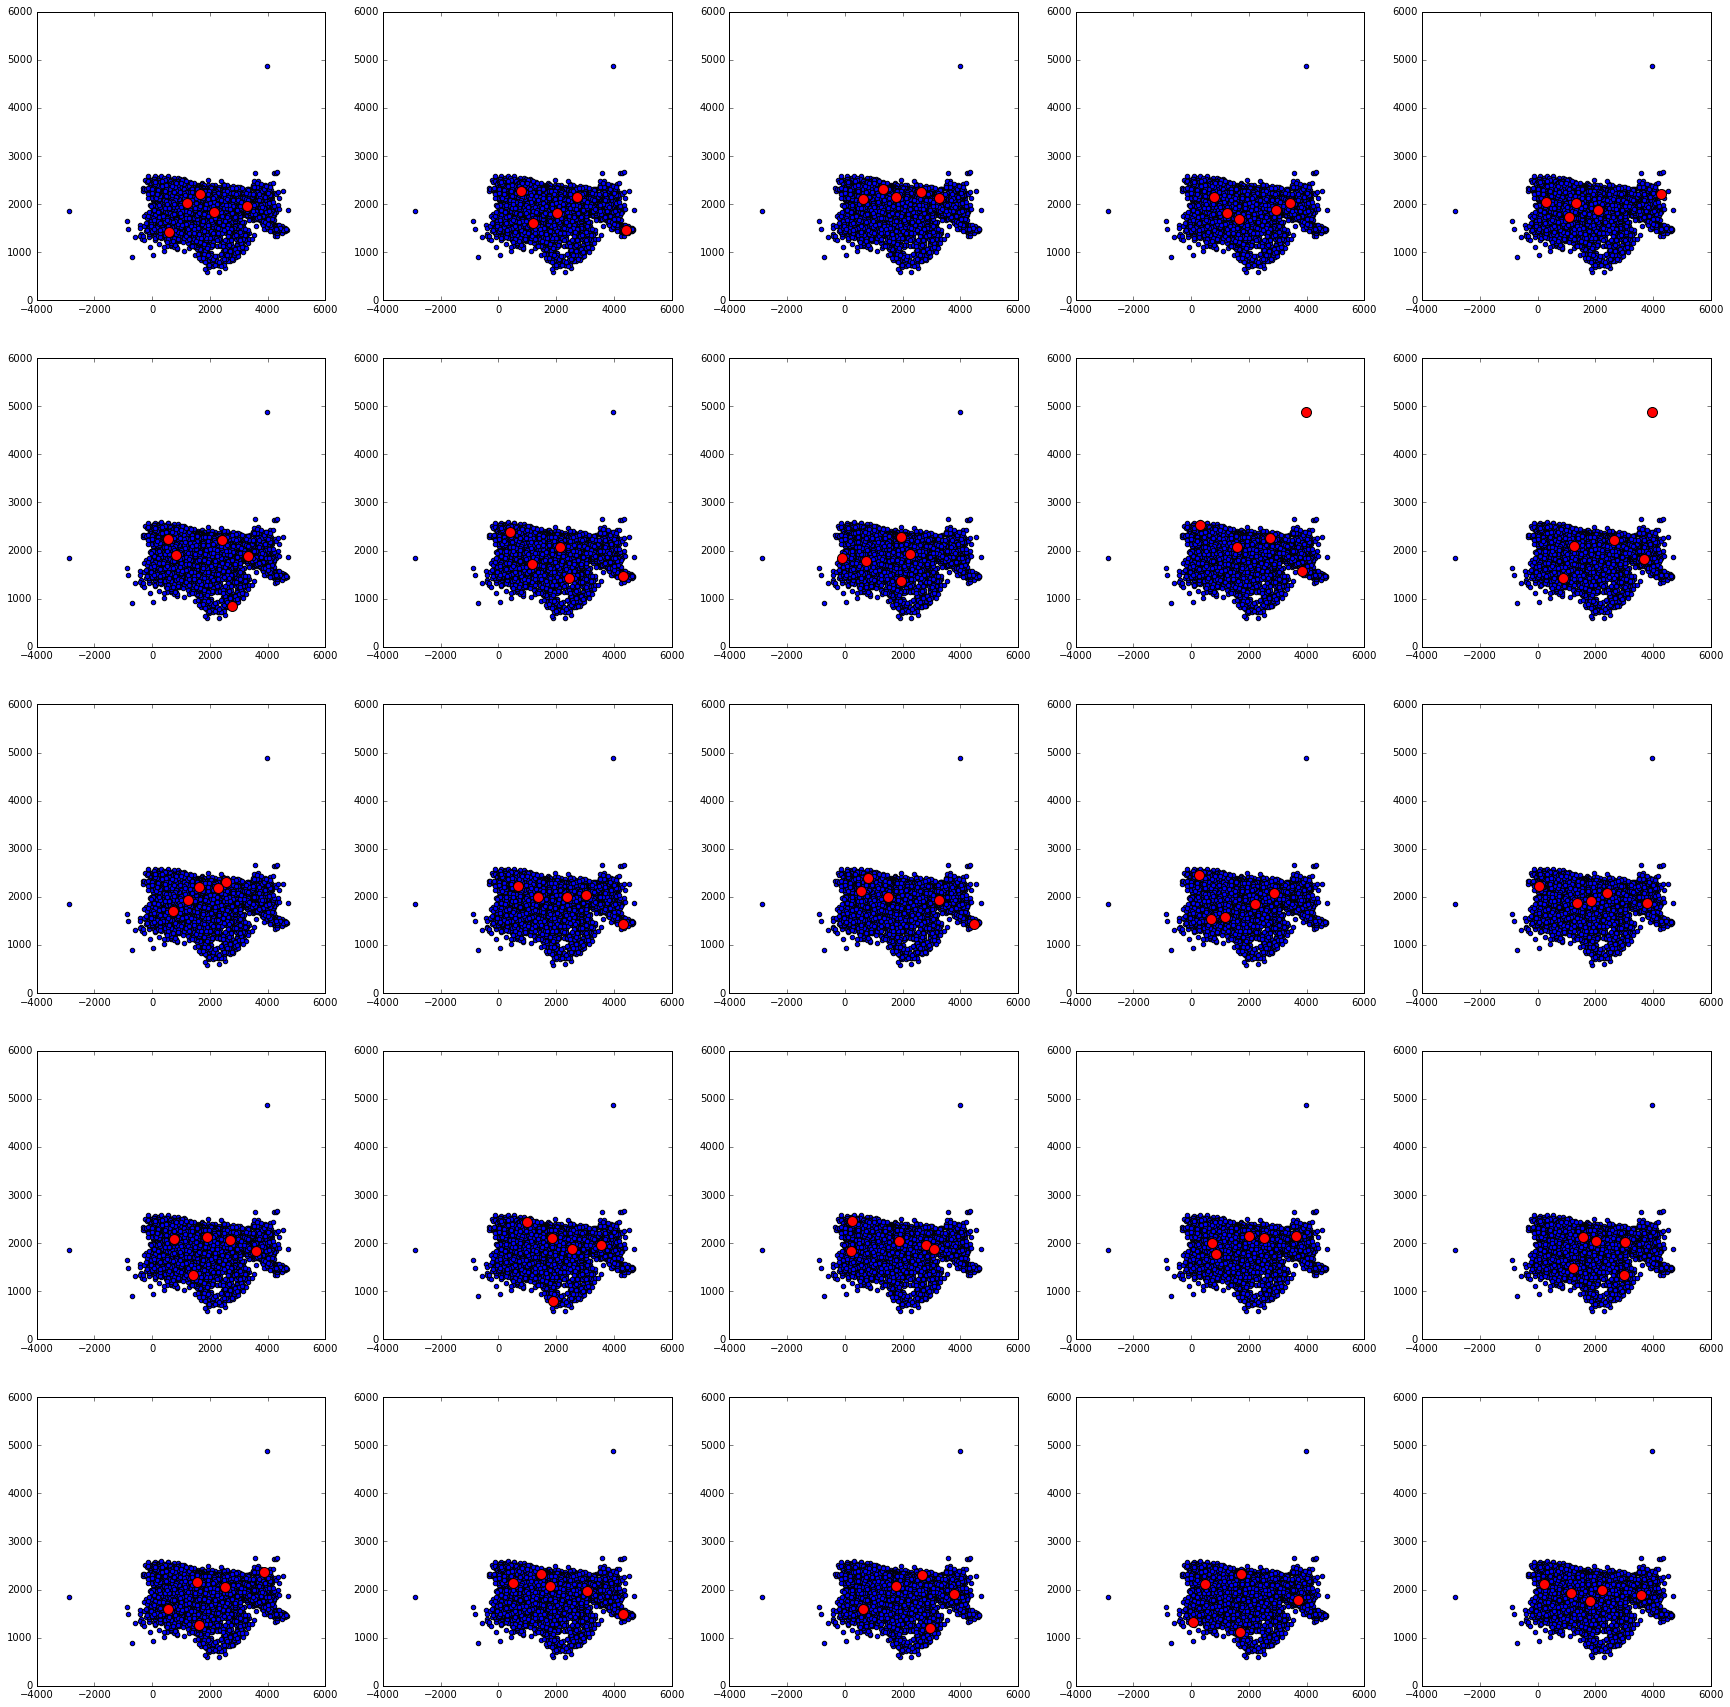

In [21]:
# Plotting cluster centers
%matplotlib inline
plt.figure(figsize=(30,30),dpi=300)
for i in range(25):
    plt.subplot(5,5,i+1)
    l=k_points[i]
    x1=[]
    y1=[]
    for i in range(len(l)):
        x1.append(l[i][0])
        y1.append(l[i][1])
    plt.scatter(x_pop,y_pop,c='b')
    plt.scatter(x1,y1,c='r',s=100)

In [22]:


# main code

import time

st = time.time()

np.random.seed(RANDOM_SEED)
centroids = kmeans(rdd, K, RUNS, converge_dist, np.random.randint(1000))
group = rdd.mapValues(lambda p: get_closest(p, centroids)) \
           .collect()

print "Time takes to converge:", time.time() - st



Initialized.
Iteration 5 max shift: 2411.49 (time: 47.27)
Iteration 10 max shift: 1363.03 (time: 45.26)
Iteration 15 max shift: 471.21 (time: 45.40)
Iteration 20 max shift: 477.92 (time: 60.63)
Iteration 25 max shift: 238.39 (time: 50.75)
Iteration 30 max shift: 184.05 (time: 51.96)
Iteration 35 max shift: 45.98 (time: 49.57)
Iteration 40 max shift: 42.69 (time: 51.09)
Iteration 45 max shift: 15.59 (time: 45.94)
Iteration 50 max shift: 3.65 (time: 49.51)
Time takes to converge: 621.400860786


## Verify your results
Verify your results by computing the objective function of the k-means clustering problem.

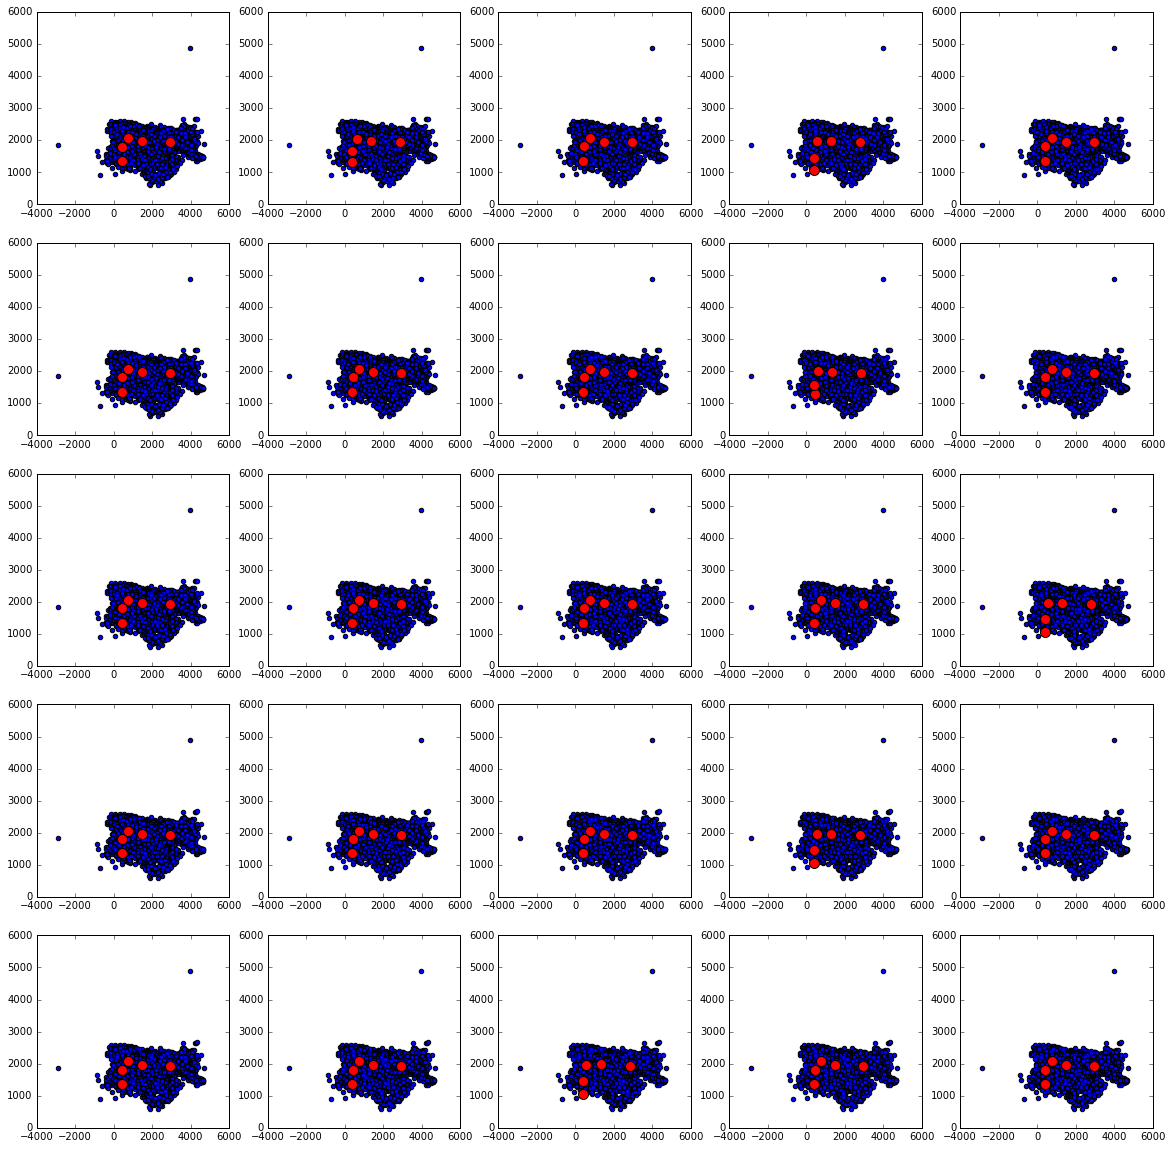

In [23]:
%matplotlib inline
plt.figure(figsize=(20,20),dpi=300)
for i in range(25):
    plt.subplot(5,5,i+1)
    l=centroids[i]
    x1=[]
    y1=[]
    for i in range(len(l)):
        x1.append(l[i][0])
        y1.append(l[i][1])
    plt.scatter(x_pop,y_pop,c='b')
    plt.scatter(x1,y1,c='r',s=100)

In [24]:
def get_cost(rdd, centers):
    '''
    Compute the square of l2 norm from each data point in `rdd`
    to the centroids in `centers`
    '''
    def _get_cost(p, centers):
        best = [0] * len(centers)
        closest = [np.inf] * len(centers)
        for idx in range(len(centers)):
            for j in range(len(centers[0])):
                temp_dist = norm(p - centers[idx][j])
                if temp_dist < closest[idx]:
                    closest[idx] = temp_dist
                    best[idx] = j
        return np.array(closest)**2
    
    cost = rdd.map(lambda (name, v): _get_cost(v, centroids)).collect()
    return np.array(cost).sum(axis=0)

cost = get_cost(rdd, centroids)

In [25]:
log2 = np.log2

print log2(np.max(cost)), log2(np.min(cost)), log2(np.mean(cost))
#33.8254902123 33.7575332525 33.7790236109


33.8254902123 33.7575332525 33.7691713358


## Plot the increase of entropy after multiple runs of k-means++

In [26]:
entropy = []

for i in range(RUNS):
    count = {}
    for g, sig in group:
        _s = ','.join(map(str, sig[:(i + 1)]))
        count[_s] = count.get(_s, 0) + 1
    entropy.append(compute_entropy(count.values()))

**Note:** Remove this cell before submitting to PyBolt (PyBolt does not fully support matplotlib)

5.4005846184328066

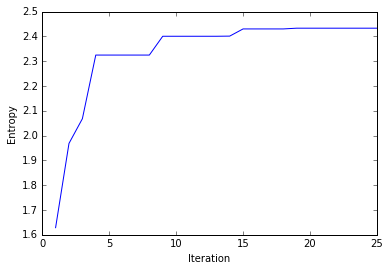

In [27]:
%matplotlib inline

plt.xlabel("Iteration")
plt.ylabel("Entropy")
plt.plot(range(1, RUNS + 1), entropy)
2**entropy[-1]

## Print the final results

In [28]:
print 'entropy=',entropy
best = np.argmin(cost)
print 'best_centers=',list(centroids[best])

entropy= [1.628753856675321, 1.9684846980688939, 2.0680629837481304, 2.3247245778481087, 2.3247245778481087, 2.3247245778481087, 2.3247245778481087, 2.3247245778481087, 2.4005520874217305, 2.4005520874217305, 2.4005520874217301, 2.4005520874217301, 2.4005520874217301, 2.4011271966515677, 2.4301221736211924, 2.4301221736211929, 2.4301221736211924, 2.4301221736211924, 2.43311558884302, 2.43311558884302, 2.4331155888430205, 2.43311558884302, 2.4331155888430205, 2.4331155888430205, 2.43311558884302]
best_centers= [array([  428.4738994 ,  1807.58033164,    35.14799298, -2574.43476306,
        -180.39839191,   263.09089521,  6048.90511888,  -743.20856056,
         256.68319372]), array([   408.29696084,   1353.92836359,     56.37619358,  -2206.17029272,
         -221.37785013,    183.25193705,  18757.57406286,  -5513.4828535 ,
         1476.58182765]), array([ 1492.0570036 ,  1954.30230067,    94.48584365, -2567.99675086,
        -112.2682711 ,   152.28015089,   395.84574671,   131.09390181,